# Tutorial introductorio a Keras


En el mundo del DL en Python hay dos grandes frameworks (es decir librerías que han crecido como para ser algo más que conjuntos de módulos y funciones): TensorFlow (Google) y Pytorch (Meta). Ambos son superpotentes y son un mix entre numpy triple plus y sklearn para iniciados. Son muy flexibles y tienen muchas funcionalidades... El precio, el de siempre, complejas, necesitan una curva de aprendizaje alto, un manejo de matrices y tensores fluido, etc, etc Para simplificar la vida del Data Science aparece Keras como recubrimiento de TensorFlow y con el tiempo se relacionan tanto que TensorFlow absorbe Keras y ahora es parte de TensorFlow, pero no por ello ha perdido esa magia de ofrecernos DL a un esfuerzo considerablmente menor que con TensorFlow. 

¿Qué vamos a ver nosotros? Un manejo relativamente introductorio pero con bastantes posibilidades. Pero aquí te dejo la documentación para que profundices si te interesa el tema porque es realmente un gran framework o un gran recubrimiento:

[Documentación](https://keras.io/guides/)

Empezamos importando librerías

In [3]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd


### Carga de Datos (con train y test split incluido)

Para ver como usar Keras y repasar algunos conceptos de DL y la forma de trabajar con él, vamos a crearnos un modelo de clasificación de imágenes con redes densas (o perceptrones multicapa), es decir con capas ocultas totalmente conectadas. Eso nos permitirá ir conociendo cómo hacerlo con Keras y diferentes opciones del mismo. Empecemos con los datos.

Cargamos los datos de mnist, el dataset de números "a mano" más famoso de la esfera del DataScience. Y como todavía no hemos vistos las redes que pueden trabajar con las imagenes en 2D, haremos la vectorización de las imágenes que hemos practicado otras veces. Es decir, todos los pixeles se convertirán en un vector de 28x28 features independientes, que serán las entradas del modelo.

In [4]:
# Cogemos las imágenes de los dígitos asi como el conjunto de train y test
(X_train, y_train), (X_test, y_test) = keras.datasets.mnist.load_data()

Vemos dimensiones del dataset

In [5]:
'''
60.000 imagenes de 28x28 pixeles
'''
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(60000, 28, 28)
(60000,)
(10000, 28, 28)
(10000,)


In [6]:
X_train.size

47040000

60.000 imágenes de 28x28 pixeles. Vamos a representar una de ellas

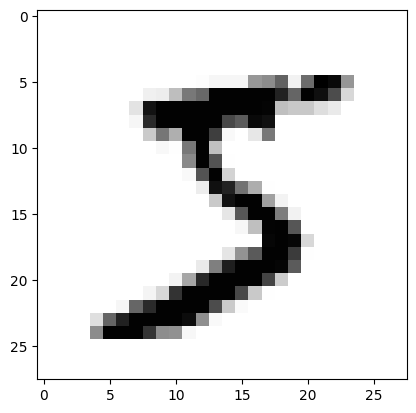

In [7]:
plt.imshow(X_train[0], cmap='Greys');

In [8]:
y_train[0]

5

In [9]:
X_train[25000,12,18]

246

In [10]:
X_train.shape

(60000, 28, 28)

### MiniEDA/Tratamiento de features

Como "buen" miniEDA DL solo vamos a ver el target y a normalizar las features (¿recuerdas cómo nos fue con los pingüinos?)

In [11]:
pd.Series(y_train).value_counts(normalize = True) # Un detalle interesante en DL es bastante normal tratar directamente con arrays de numpy y no con dataframes, mas si son imágenes

1    0.112367
7    0.104417
3    0.102183
2    0.099300
9    0.099150
0    0.098717
6    0.098633
8    0.097517
4    0.097367
5    0.090350
Name: proportion, dtype: float64

El dataset está bastante equilibrado (los modelos de DL admiten también el equivalente a class_weight para balancear), con una ligera deriva hacia el 1, el 7 y el 3

#### Escalado

Podemos usar un MinMaxScaler o un StandardScaler, pero en este caso hay una forma muy directa, ya que los valores de escala de grises de las imágenes van entre 0 y 255, con lo que hacer un equivalente al MinMaxScaler es muy directa

In [12]:
# Preprocess the data (these are NumPy arrays). Aplano a una dimension cada imagen.
# Escalamos ya que vamos a usar gradient descent, y le afecta mucho la escala de las features.
# Ejecutar esta celda solo una vez. Sino reescalará

X_train = X_train.astype("float32") / 255
X_test = X_test.astype("float32") / 255

y_train = y_train.astype("float32")
y_test = y_test.astype("float32")

In [13]:
'''
Comprobamos la normalización
'''
X_train[0]

array([[0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.    

### ¿Y el Validation_set?

En el tratamiento de modelos de DL lo normal es no usar validación cruzada (en general porque no tendremos modelos "alternativos" al que estemos construyendo y también porque lo pesado de los entrenamientos hace costoso en tiempo poder usar esta forma de comparación). Lo que se suele hacer es tener un dataset de Validación. Para ello, ya que nos han dado los datasets separados, podemos "cortar un cacho" del train.

Guardamos datos para validación. Estos datos se usarán durante el entrenamiento. Otra opción es decirle a Keras en la etapa de entrenamiento que reserve un X % de los datos para validar (como argumento del método `fit`).

In [14]:
# Reserve 10,000 samples for validation. Entraran dentro del modelo para validar. No es validacion cruzada
X_val = X_train[-10000:]
y_val = y_train[-10000:]

X_train = X_train[:-10000]
y_train = y_train[:-10000]

print(X_val)

[[[0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  ...
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]]

 [[0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  ...
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]]

 [[0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  ...
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]]

 ...

 [[0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  ...
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]]

 [[0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  ...
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]]

 [[0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  ...
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]]]


In [15]:
pd.Series(y_val).value_counts(True)

7.0    0.1090
1.0    0.1064
3.0    0.1030
8.0    0.1009
0.0    0.0991
2.0    0.0990
4.0    0.0983
6.0    0.0967
9.0    0.0961
5.0    0.0915
Name: proportion, dtype: float64

Además nos ha mantenido bastante bien la estratificación.

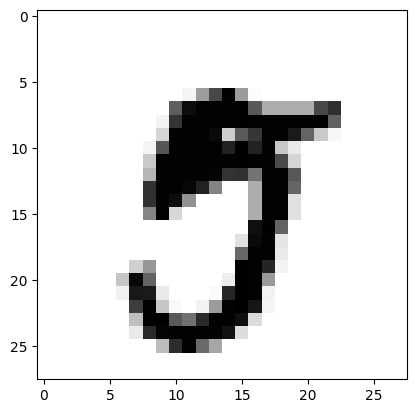

In [16]:
plt.imshow(X_val[1234], cmap='Greys')

In [17]:
y_val[1234]

5.0

## DEFINICION/CONSTRUCCION

Para este problema vamos a construir una topología "sencilla" multicapa completamente conectada. O sea un MLP (aunque no tendrán el step como fuciones de activación) o una red densa. Recordando lo que vimos en la sesión de WrapUp de la unidad anterior. Vamos a montar la siguiente red:

<img src="./img/mlp_clasification.png" alt="drawing" width="300"/>

¿Cómo construimos con Keras? Vamos a utilizar "layers" diferentes tipos de capas que podemos ajustar entre si como bloques de lego. Evidentemente tendremos una layer "densa" con sus neuronas y unidades pero también capas que hacen otro tipo de funciones y no se entrenan, y capas más complejas que sí se entrenan y que iremos viendo en sucesivos sprints. 

En nuestro caso para implementar una topología sencilla como la anterior aplicada a nuestro problema específico de clasificación de MNIST usaremos las siguientes capas (layers) de Keras:

* **Sequential**: API para iniciar la red neuronal. No cuenta como capa.
* **Flatten**: capa de entrada especial. Necesita un vector unidimensional. Como tenemos imágenes, esta capa aplana las imagenes (2D) en 1D.
* **Dense**: es una hidden layer. Cada hidden layer se compondrá de `n` neuronas y de una función de activación que se aplicará a todas las neuronas de la capa. La capa de salida también serás densa (porque sus unidades o neuronas estarán conectadas a todas las unidades de la capa anteriore) pero como es un problema de clasificación multiclase (10 clases), se compondrá de tantas neuronas como clases tengamos (o sea... muy bien, diez unidades o neuronas).



#### Softmax

Un poco más sobre la activación softmax:    

Fórmula:  
<img src="./img/softmax_function.png" alt="drawing" width="400"/>

Función de transferencia:  
<img src="./img/softmax_activation.png" alt="drawing" width="400"/>

Ejemplo de funcionamiento:  
<img src="./img/softmax_example.png" alt="drawing" width="400"/>

$$Softmax(5) = \frac{e^5}{e^5+e^{2.5}+e^{0.5}} = \frac{148.41}{148.41 + 12.18 + 1.65} = 0.91$$

Es una activación un poco especial porque no afecta a una unidad por separado sino que se aplica al conjunto de unidades y da una salida para cada una.

A construir...

#### Construcción "apilando"

In [18]:
# Una manera de declarar la red neuronal

# Siempre hay que declarar la capa sequential para empezar a declarar la red
# Se trata de la API sequential
model = keras.models.Sequential()

# Flatten, aplana en un unico vector. Y especificamos el tamaño de la entrada
# Es como si hiciese un .reshape(-1, 28*28)
# "kernel_initializer" o "bias_initializer" No lo usamos pero seria para inicializar los pesos de otra manera
model.add(keras.layers.Flatten(input_shape=(28,28)))

# Capas de la red. Dense es la capa de neuronas. Necesitamos numero y activacion
model.add(keras.layers.Dense(units = 300, # Numero de neuronas de la capa
                             activation='relu'))

model.add(keras.layers.Dense(100,
                             activation='relu'))

# Capa de salida, con tamaño del número de clases
# Suele ir aqui un softmax. Para multiclase guay. Si es binaria -> sigmoide
model.add(keras.layers.Dense(10, activation='softmax'))

#### Construcción con listas (secuencias de capas)

In [19]:
# Otra manera de declarar la red neuronal
capas = [
    keras.layers.Flatten(input_shape=(28,28)),
    keras.layers.Dense(300, activation='relu'),
    keras.layers.Dense(100, activation='relu'),
    keras.layers.Dense(10, activation='softmax')
]
model = keras.models.Sequential(capas)

#### Usando la denominada "Functional API"

La functional API de Keras va encadenando capas como si fueran llamadas de funciones entre sí, es un poco más compleja pero permite topologías mucho más ricas

In [20]:
# Y una forma mediante encademaniento de funciones (usando lo que se denomina la Functional API)
input_layer = keras.layers.Input(shape = (28,28))
flatten_layer = keras.layers.Flatten()(input_layer)
hidden_1 = keras.layers.Dense(300, activation = "relu")(flatten_layer)
hidden_2 = keras.layers.Dense(100, activation = "relu")(hidden_1)
output = keras.layers.Dense(10, activation = "softmax")(hidden_2)
model = keras.Model(inputs = [input_layer], outputs = [output])

La functional API me va a permitir construir redes como estas:

<img src="./img/otras_arquitecturas.png" alt="drawing" width="600"/>

Podemos ver las capas, y acceder a sus elementos

In [21]:
print(model.layers[1])
model.layers

Podemos ver los pesos de las capas sin entrenar, porque los inicializa "aleatoriamente". Los bias los inicializa a 0.

In [22]:
hidden1 = model.layers[2]
weights, biases = hidden1.get_weights()

# 784 features (pixeles de las imagenes) x 300 neuronas
# Los pesos están inicializados aleatoriamente
weights.shape

(784, 300)

In [23]:
weights.size

235200

In [24]:
weights[0]

array([ 1.6138576e-02,  5.6994841e-02,  9.0306103e-03, -6.4078934e-02,
       -4.3126114e-02,  1.8584251e-02, -4.2706296e-02,  2.9420324e-02,
       -7.8710839e-03,  4.6283700e-02,  3.5908781e-02,  2.5099009e-02,
       -3.3486620e-02, -5.8439948e-02,  5.2306637e-02,  6.7875504e-02,
       -2.9248126e-02,  5.9519097e-02, -3.9113238e-03,  2.6010007e-02,
        4.7256708e-02, -6.0906984e-02, -6.0259372e-02,  2.8091073e-03,
        5.9927210e-02,  4.4061519e-02, -5.7780936e-02, -6.1695039e-02,
       -5.4998294e-02,  3.8757101e-02, -4.8638433e-03, -6.6033185e-02,
       -7.7471659e-03,  4.3047130e-02, -9.6922442e-03, -7.2182812e-02,
        3.2182887e-02,  3.7157856e-02, -4.5553558e-02, -4.9954940e-02,
       -3.4010116e-02,  4.2360708e-02, -5.7887062e-02,  5.4764375e-03,
        2.1348126e-02,  1.2311190e-02,  6.6928864e-02,  7.0595607e-02,
       -6.5892138e-02, -3.8718011e-02, -2.9900577e-02, -8.1890374e-03,
        4.0696524e-02,  1.8959284e-02,  7.0064232e-02,  4.6091899e-02,
      

Sí, podríamo ya hacer una predicción

In [25]:
model.predict([X_train[1234:1235,:]]) # Espera batches o conjunto de valores por eso hay que dárselo así

1/1 [==============================] - 0s 159ms/step


array([[0.10437898, 0.11766145, 0.08656988, 0.09521522, 0.11696028,
        0.09662782, 0.08775973, 0.0979524 , 0.12455237, 0.07232182]],
      dtype=float32)

Tenemos tantas salidas como neuronas y son "probabilidades", tendremos que hacer nosotros la conversión:

In [26]:
model.predict([X_train[1234:1235,:]])[0].argmax()

1/1 [==============================] - 0s 15ms/step


8

Nuestra modelo no entrenado pero inicializado dice que 3... y es

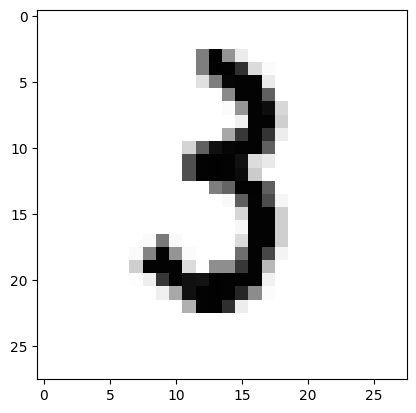

In [27]:
plt.imshow(X_train[1234], cmap = "Greys")

¿No esperarías otra cosa? :-)

#### Inicializadores:  

Antes de seguir y al hilo de lo que vimos de los pesos al finalizar la sección anterior, hay que recordar que cuando construimos un modelo o red DL, de partida sus pesos se inicializan a valores diferentes de cero (si no, no habría gradiente que propagar ni nada que hacer). Esa inicialización afecta al comportamiento de la red, y no es un aleatorio cualquiera. Lo iremos recordando... De hecho el tipo de inicialización es un hiperparámetro. Ahora ya puedes obviar parcialmente el inciso y sigamos...

O sea:

- Los pesos inicializados a cero -> No aprendizaje
- Desde siempre se inicializan "aleatoriamente", pero no sólo de forma uniforme (todos los valores con la misma probabilidad), sino que se emplean diferentes distribuciones de probabilidad con parámetros que dependen del número de entradas y salidas de la capa. El objetivo esintentar que las varianzas de las entradas sean similares a las de las salidas y evitar el problema del gradiente que se desvanece ("Vanishing Gradient" problem):  
    *   Glorot inizialization (por defecto la de Keras, con función uniforme de distribución) -> Para cuando tienes funciones de activación (ninguna, tanh, sigmoid, softmax, aunque también se usa por defecto :-) para casi todo) [Xavier Glorot & Yoshua Bengio]
    *   He inizialization, -> Para cuando tienes ReLU, Leaky ReLU, ELU, GELU, Swish, Mish [He Kaiming et al.]
    *   LeCunn inizialization -> Para cuando tienes SELU [Jean LeCunn]
- Es un hiperparámetro

Establecemos la configuración de ejecución... el compile.

In [28]:
# Se especifica la configuración del entrenamiento (optimizador, pérdida, métricas):
model.compile(
    # Stocastic gradient descent. El algoritmo para minimizar la loss function
    # El stocastic va haciendo muestreo en cada evaluacion, no usa todo el dataset
    # Podemos modificar el learning rate(0.01 por defecto) mediante el parametro lr
    optimizer=keras.optimizers.SGD(),  # Optimizer, con parámetros por defecto
    
    
    # Loss function to minimize
    # sparse_categorical_crossentropy cuando tenemos un label en nuna columna
    # Si lo tuviesemos en varias tipo dummy, cogeriamos categorical_crossentropy
    # binary_crossentropy si es una neurona, clasi binario
    loss=keras.losses.SparseCategoricalCrossentropy(),
    
    # List of metrics to monitor
    metrics=[keras.metrics.SparseCategoricalAccuracy()],
)

In [29]:
# Equivalente (... casi, los parámetros del optimizador serán los que tenga por defecto)
model.compile(optimizer="sgd",
              loss="sparse_categorical_crossentropy",
              metrics=["accuracy"])

In [30]:
# Summary
# La primera hidden layer tiene 784 entradas x 300 salidas
# Son los 235500 params = 784x300 + 300 (bias)
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 28, 28)]          0         
                                                                 
 flatten_2 (Flatten)         (None, 784)               0         
                                                                 
 dense_6 (Dense)             (None, 300)               235500    
                                                                 
 dense_7 (Dense)             (None, 100)               30100     
                                                                 
 dense_8 (Dense)             (None, 10)                1010      
                                                                 
Total params: 266610 (1.02 MB)
Trainable params: 266610 (1.02 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


#### CAPAS

Vayamos construyendo nuestra __lista de capas__:

__Entrenables__:  
__* Dense__ -> Capa completamente conectada a las neuronas de la capa anterior y a la posterior  
    Hiperparámetros asociados:     
        * units: Number of neurons, dimensionality of the output space  
        * activation: Activation function to use. If you don't specify anything, no activation is applied  
        * kernel_initializer: Initializer for the kernel weights matrix.  
        * bias_initializer: Initializer for the bias vector. (Suelen inicializarse a cero)
        * Kernel_regularizar: Los clásicos (L1,L2,...)
 
__Funcionales__:       
__* Input__ -> Capa para definir la forma de la entrada (shape), que se puede pasar como input_shape  
__* Flatten__ -> Capa que aplana (convierte su entrada en un vector)

### Funciones Activacion

Otras funciones de activación interesantes: SELU (1.67*ELU) y Swish (también SiLU, o Sigmoid linear unit)... No entrar en pánico, vais a usar ReLU, Softmax y no-activation, y en algunos casos (quizás): sigmoid, tanh y las (x)LU (SELU, Siwsh,etc)

<img src="./img/activation_functions.png" alt="drawing" width="600"/>



#### OPTIMIZADORES

Y también vamos completando lista de hiperparámetros, estos asociados al "Optimizador"/"Modelo":  
Tipo de optimizador:  
* __SGD__, Gradient descent "genérico" (puedes añadirle "momento", es decir que a la hora de descontar el gradiente tenga en cuenta el vector medio de gradientes pasados)
  

* __Adagrad__, Hace gradient descent pero ajusta el gradiente para compensar las componentes de mayor valor numérico (es como evitar irse por las pendientes más inclinadas)... Es decir evita irse a mínimos locales al precio de enlentecer el entrenamiento.    

* __RMSprop__, Versión de AdaGrad, pero considera principalmente los últimos valores del gradiente. Es decir, busca lo bueno de Adagrad reduciendo sus peligros.    

* __Adam__, _Adaptative Moment Estimation_, combina RMSProp y el uso de momento. Es el rey actual (junto con sus versiones) para grandes cantidades de datos.    

* __AdamW, Nadam, AdaMax__, variantes del anterior. 

Comparativa, donde * es malo y *** bueno (extraído del "Hands-on Machine Learning with...." de Aurelien Geron, 3a Edicion)

<img src="./img/Comparativa-optimizadores.png" alt="drawing" width="800"/>

Keras también permite:
__Adadelta__ _(variante de Adagrad)_, __Adafactor__ y __Ftrl__

      
Hiperparámetros Genéricos:
Learning Rate: Coeficiente aplicado al descenso de gradiente, como en otros modelos que ya hemos visto  
Asociados al Gradient Clipping: clipnorm, clipvalue, global_clipnorm

Cada optimizador además puede tener sus propios hiperparámetros (ver: https://keras.io/api/optimizers/)

 




### Fuciones de pérdida y métricas
__Función de perdida__: La función a minimizar durante el entrenamiento (son las mismas que en otros modelos no Deep)  
- Clasificación: En clases Keras -> __BinaryCrossEntropy, CategoricalCrossEntropy, SparseCategoricalCrossEntropy__  
- Regresión: En clases Keras -> __MeanSquaredError, MeanAbsoluteError, MeanAbsolutePercentageError, CosineSimilarity__   

__Métricas__:  
- Regresión: __MAE, MSE, MAPE__ :-)  
- Clasificación: __Accuracy, Precision, Recall, f1, AuRoC__  

¿Cuál es la diferencia entre Categorical y Sparse? ¿Por qué las funciones de pérdida son diferentes a las métricas en Clasificación? 

## ENTRENAMIENTO

Entrenamos el modelo. Usamos los datos de entrenamiento. El __batch_size__ es la cantidad de muestras que utiliza el SGD, y las __epochs__ son las iteraciones que realiza en el entrenamiento. (Son hiperparámetros de entrenamiento)    

En una epoch se entrenan tantos batches como sea necesario para recorrer todo el dataset.

In [31]:
50000/64

781.25

In [32]:
# Entrenamos el modelo con un batch_size de 64 imágenes por cada iteración, 15 epochs y especificando cuál es el conjunto de validación.
print("Fit model on training data")
history = model.fit(
    X_train,
    y_train,
    batch_size=64, # numero de muestras empleadas en el entrenamiento de SGD
    epochs=15, # 1 por defecto. Insuficiente. Numero de vueltas del backpropagation
    # We pass some validation for
    # monitoring validation loss and metrics
    # at the end of each epoch
    # En vez de validation data podemos usar el argumento validation_split=0.1
    validation_data=(X_val, y_val)
)
'''
En el entreanamiento solo hay que fijarse que el loss va para abajo, es bueno.
Si vemos que ya no baja mas, no serán necesarias tantas epochs.
Imprimera tantas lineas como epochs hayamos puesto

Tampoco usamos el class_weight, que le da más peso a las clases con pocas muestras
Util para datasets desbalanceados.

El loss que muestra es el categoricalcrossentropy
'''


Fit model on training data
Epoch 1/15


782/782 [==============================] - 2s 2ms/step - loss: 0.8703 - accuracy: 0.7816 - val_loss: 0.3891 - val_accuracy: 0.8984
Epoch 2/15
782/782 [==============================] - 1s 2ms/step - loss: 0.3707 - accuracy: 0.8980 - val_loss: 0.2998 - val_accuracy: 0.9178
Epoch 3/15
782/782 [==============================] - 1s 2ms/step - loss: 0.3075 - accuracy: 0.9129 - val_loss: 0.2671 - val_accuracy: 0.9262
Epoch 4/15
782/782 [==============================] - 1s 2ms/step - loss: 0.2736 - accuracy: 0.9221 - val_loss: 0.2407 - val_accuracy: 0.9336
Epoch 5/15
782/782 [==============================] - 1s 2ms/step - loss: 0.2493 - accuracy: 0.9302 - val_loss: 0.2234 - val_accuracy: 0.9378
Epoch 6/15
782/782 [==============================] - 1s 2ms/step - loss: 0.2301 - accuracy: 0.9347 - val_loss: 0.2074 - val_accuracy: 0.9415
Epoch 7/15
782/782 [==============================] - 1s 2ms/step - loss: 0.2136 - accuracy: 0.9394 - val_loss: 0.1947 

'\nEn el entreanamiento solo hay que fijarse que el loss va para abajo, es bueno.\nSi vemos que ya no baja mas, no serán necesarias tantas epochs.\nImprimera tantas lineas como epochs hayamos puesto\n\nTampoco usamos el class_weight, que le da más peso a las clases con pocas muestras\nUtil para datasets desbalanceados.\n\nEl loss que muestra es el categoricalcrossentropy\n'

**Podemos reentrenar el modelo. No empieza de nuevo, sino que retoma el entrenamiento anterior.**

In [33]:
model.fit(
    X_train,
    y_train,
    batch_size=64,
    epochs=15,
    validation_data=(X_val, y_val)
)

Epoch 1/15
782/782 [==============================] - 1s 2ms/step - loss: 0.1258 - accuracy: 0.9642 - val_loss: 0.1312 - val_accuracy: 0.9659
Epoch 2/15
782/782 [==============================] - 1s 2ms/step - loss: 0.1200 - accuracy: 0.9663 - val_loss: 0.1261 - val_accuracy: 0.9663
Epoch 3/15
782/782 [==============================] - 1s 2ms/step - loss: 0.1144 - accuracy: 0.9679 - val_loss: 0.1250 - val_accuracy: 0.9666
Epoch 4/15
782/782 [==============================] - 1s 2ms/step - loss: 0.1093 - accuracy: 0.9697 - val_loss: 0.1200 - val_accuracy: 0.9672
Epoch 5/15
782/782 [==============================] - 1s 2ms/step - loss: 0.1046 - accuracy: 0.9709 - val_loss: 0.1182 - val_accuracy: 0.9676
Epoch 6/15
782/782 [==============================] - 1s 2ms/step - loss: 0.1000 - accuracy: 0.9722 - val_loss: 0.1137 - val_accuracy: 0.9696
Epoch 7/15
782/782 [==============================] - 1s 2ms/step - loss: 0.0958 - accuracy: 0.9733 - val_loss: 0.1102 - val_accuracy: 0.9692
Epoch 

Veamos el histórico del entrenamiento, para poder representarlo posteriormente.

In [34]:
print(history.params)
print(history.epoch)
history.history

{'verbose': 1, 'epochs': 15, 'steps': 782}
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14]


{'loss': [0.8703155517578125,
  0.37068256735801697,
  0.3075453042984009,
  0.27360999584198,
  0.24932800233364105,
  0.23011012375354767,
  0.21364650130271912,
  0.19892580807209015,
  0.18636642396450043,
  0.1747034639120102,
  0.164808988571167,
  0.15560577809810638,
  0.1469438374042511,
  0.13952140510082245,
  0.13208380341529846],
 'accuracy': [0.7815799713134766,
  0.8979600071907043,
  0.9129400253295898,
  0.9221199750900269,
  0.9302200078964233,
  0.9347400069236755,
  0.9394199848175049,
  0.9434199929237366,
  0.9462599754333496,
  0.9492400288581848,
  0.9529799818992615,
  0.9558200240135193,
  0.9582599997520447,
  0.9604399800300598,
  0.9625399708747864],
 'val_loss': [0.3890865743160248,
  0.2997979521751404,
  0.267111599445343,
  0.24066948890686035,
  0.22343853116035461,
  0.20740656554698944,
  0.19473594427108765,
  0.18402056396007538,
  0.1744401454925537,
  0.16569460928440094,
  0.15931689739227295,
  0.1517241895198822,
  0.1445324718952179,
  0.1396

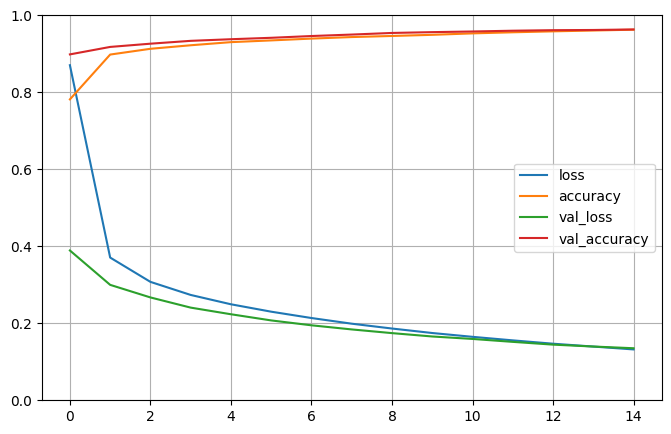

In [35]:
import pandas as pd
import matplotlib.pyplot as plt

# Podemos ver como evoluciona el entrenamiento, en funcion de los epochs
# Validacion y training estan muy cerca, no hay overfitting!
# Todavia no ha acabado de coverger ya que el loss en validacion sigue bajando,
pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1) # set the vertical range to [0-1]
plt.show()

Si el modelo no ha ido bien, prueba a cambiar el learning rate, cambia de optimizador y después prueba a cambiar capas, neuronas y funciones de activación.


### Evaluación con test

Ya tenemos el modelo entrenado. Probémoslo con test

In [36]:
# Obtenemos el "score" a partir del conjunto de test
# Evaluate the model on the test data using `evaluate`
print("Evaluate on test data")

# Metodo evaluate para que nos de el error vs las metricas elegidas en la funcion compile
results = model.evaluate(X_test, y_test)
print("test loss, test acc:", results)

Evaluate on test data
313/313 [==============================] - 0s 697us/step - loss: 0.0951 - accuracy: 0.9712
test loss, test acc: [0.0951104462146759, 0.9711999893188477]


C:\Users\lucas\AppData\Local\Temp\ipykernel_13380\1468152043.py:2: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  plt.imshow(X_test[0].reshape(28,28), cmap=plt.cm.get_cmap('Greys'));


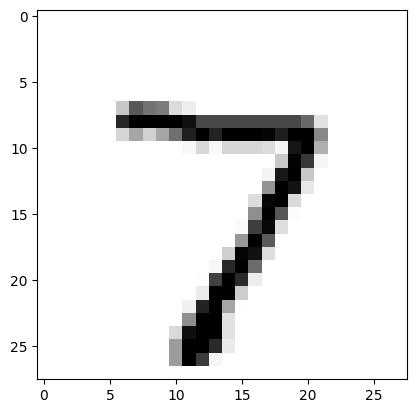

In [38]:
# Cogemos el primero
plt.imshow(X_test[0].reshape(28,28), cmap=plt.cm.get_cmap('Greys'));

In [37]:
'''
Ojo aqui viene slicing xq presupone que le entran varios inputs
Nos da las probabilidades de pertenecer a una clase u otra.
'''
predictions = model.predict(X_test[:1]).round(3)
print("predictions shape:", predictions.shape)
print(predictions[0])
print(np.argmax(predictions[0]))

1/1 [==============================] - 0s 39ms/step
predictions shape: (1, 10)
[0.    0.    0.001 0.001 0.    0.    0.    0.998 0.    0.   ]
7


In [39]:
predictions.max()

0.998

In [40]:
predictions.argmax()

7

In [41]:
y_pred = [np.argmax(predictions) for predictions in model.predict(X_test)]
y_pred[0:5]

313/313 [==============================] - 0s 707us/step


[7, 2, 1, 0, 4]

In [42]:
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

         0.0       0.97      0.99      0.98       980
         1.0       0.98      0.99      0.99      1135
         2.0       0.97      0.98      0.97      1032
         3.0       0.97      0.96      0.97      1010
         4.0       0.96      0.98      0.97       982
         5.0       0.96      0.98      0.97       892
         6.0       0.98      0.97      0.97       958
         7.0       0.98      0.96      0.97      1028
         8.0       0.97      0.96      0.96       974
         9.0       0.96      0.95      0.96      1009

    accuracy                           0.97     10000
   macro avg       0.97      0.97      0.97     10000
weighted avg       0.97      0.97      0.97     10000



### Problema de regresión
Veamos un ejemplo de cómo aplicar una red neuronal de TensorFlow a un problema de regresión.

In [43]:
# Cargamos datos
from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

housing = fetch_california_housing()
df = pd.DataFrame(housing.data, columns = housing.feature_names)
df['target'] = housing['target']
df.head()

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,target
0,8.3252,41.0,6.984127,1.023810,322.0,2.555556,37.88,-122.23,4.526
1,8.3014,21.0,6.238137,0.971880,2401.0,2.109842,37.86,-122.22,3.585
2,7.2574,52.0,8.288136,1.073446,496.0,2.802260,37.85,-122.24,3.521
3,5.6431,52.0,5.817352,1.073059,558.0,2.547945,37.85,-122.25,3.413
4,3.8462,52.0,6.281853,1.081081,565.0,2.181467,37.85,-122.25,3.422


Divimos en train, test y validation

In [44]:
X_train_full, X_test, y_train_full, y_test = train_test_split(housing.data,
                                                              housing.target)

X_train, X_valid, y_train, y_valid = train_test_split(X_train_full,
                                                      y_train_full)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_valid = scaler.transform(X_valid)
X_test = scaler.transform(X_test)

In [45]:
X_train.shape

(11610, 8)

Montamos el modelo. Simplemente se compondrá de una hidden layer, a la que le configuramos una capa previa de entrada de 8 neuronas (las features).

Se trata de un modelo de regresión, por lo que la capa de salida es una única neurona.
     
Vamos a configurar una red como esta:  
<img src="./img/mlp_regresion.png" alt="drawing" width="300"/>

In [46]:
model = keras.models.Sequential([
    
    # No hace falta capa de flatten. No hay que aplanar ninguna imagen
    keras.layers.Dense(30, activation="relu",
                       input_shape=X_train.shape[1:]),
    keras.layers.Dense(1) # una unica neurona de salida
    # Sin fun de activa. ReLu no iria mal si el output es positivo. Sigmoide si esta acotado.
])

model.compile(loss="mean_squared_error",
              optimizer="sgd",
              metrics = ["RootMeanSquaredError"])

history = model.fit(X_train, y_train, epochs=20,
                    validation_data=(X_valid, y_valid))

mse_test = model.evaluate(X_test, y_test)
X_new = X_test[:3] # pretend these are new instances
y_pred = model.predict(X_new)


Epoch 1/20
363/363 [==============================] - 1s 985us/step - loss: 0.9402 - root_mean_squared_error: 0.9696 - val_loss: 6.9428 - val_root_mean_squared_error: 2.6349
Epoch 2/20
363/363 [==============================] - 0s 707us/step - loss: 2.0018 - root_mean_squared_error: 1.4148 - val_loss: 0.4637 - val_root_mean_squared_error: 0.6809
Epoch 3/20
363/363 [==============================] - 0s 679us/step - loss: 0.4872 - root_mean_squared_error: 0.6980 - val_loss: 0.4276 - val_root_mean_squared_error: 0.6539
Epoch 4/20
363/363 [==============================] - 0s 671us/step - loss: 0.4337 - root_mean_squared_error: 0.6586 - val_loss: 0.4049 - val_root_mean_squared_error: 0.6363
Epoch 5/20
363/363 [==============================] - 0s 688us/step - loss: 0.4978 - root_mean_squared_error: 0.7056 - val_loss: 0.4338 - val_root_mean_squared_error: 0.6587
Epoch 6/20
363/363 [==============================] - 0s 694us/step - loss: 0.4650 - root_mean_squared_error: 0.6819 - val_loss: 0

In [47]:
print("MSE:",mse_test)

MSE: [0.36452001333236694, 0.6037549376487732]


In [48]:
history.history

{'loss': [0.9401863217353821,
  2.0017879009246826,
  0.48717886209487915,
  0.4336942136287689,
  0.49781665205955505,
  0.46503984928131104,
  0.4267135560512543,
  0.407390832901001,
  0.39607545733451843,
  0.3906225562095642,
  0.38948339223861694,
  0.38207313418388367,
  0.37706154584884644,
  0.3779582381248474,
  0.3764446973800659,
  0.36926522850990295,
  0.3785744607448578,
  0.3651924133300781,
  0.36261558532714844,
  0.3587878942489624],
 'root_mean_squared_error': [0.9696320295333862,
  1.414845585823059,
  0.6979820132255554,
  0.6585546135902405,
  0.7055612206459045,
  0.6819382905960083,
  0.6532331705093384,
  0.6382717490196228,
  0.6293452382087708,
  0.6249980330467224,
  0.6240860223770142,
  0.6181206703186035,
  0.6140533685684204,
  0.6147831082344055,
  0.6135509014129639,
  0.6076719760894775,
  0.6152840256690979,
  0.6043115258216858,
  0.6021757125854492,
  0.5989890694618225],
 'val_loss': [6.942836284637451,
  0.4636688232421875,
  0.42757514119148254

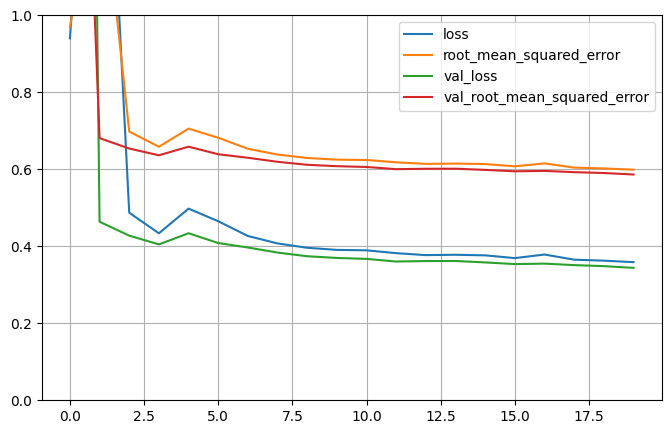

In [49]:
pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1) # set the vertical range to [0-1]
plt.show()

In [50]:
#Otra forma pure-Keras:
X_train_full, X_test, y_train_full, y_test = train_test_split(housing.data,
                                                              housing.target)

X_train, X_valid, y_train, y_valid = train_test_split(X_train_full,
                                                      y_train_full)


norm_layer = keras.layers.Normalization(input_shape = X_train.shape[1:]) # Es una Standardization
model = keras.models.Sequential([
    
    # No hace falta capa de flatten. No hay que aplanar ninguna imagen
    norm_layer,
    keras.layers.Dense(30, activation="relu"),
    keras.layers.Dense(1) # una unica neurona de salida
    # Sin fun de activa. ReLu no iria mal si el output es positivo. Sigmoide si esta acotado.
])
optimizer = keras.optimizers.SGD()
model.compile(loss="mean_squared_error",
              optimizer=optimizer, metrics = ["RootMeanSquaredError","MeanAbsoluteError"])
norm_layer.adapt(X_train)
history = model.fit(X_train, y_train, epochs=20,
                    validation_data=(X_valid, y_valid))

mse_test = model.evaluate(X_test, y_test)
X_new = X_test[:3] # pretend these are new instances
y_pred = model.predict(X_new)

Epoch 1/20
363/363 [==============================] - 1s 954us/step - loss: 0.8136 - root_mean_squared_error: 0.9020 - mean_absolute_error: 0.6369 - val_loss: 2.9207 - val_root_mean_squared_error: 1.7090 - val_mean_absolute_error: 0.5571
Epoch 2/20
363/363 [==============================] - 0s 782us/step - loss: 1.8582 - root_mean_squared_error: 1.3632 - mean_absolute_error: 0.5502 - val_loss: 0.7620 - val_root_mean_squared_error: 0.8730 - val_mean_absolute_error: 0.5905
Epoch 3/20
363/363 [==============================] - 0s 736us/step - loss: 0.4618 - root_mean_squared_error: 0.6796 - mean_absolute_error: 0.4815 - val_loss: 0.4235 - val_root_mean_squared_error: 0.6507 - val_mean_absolute_error: 0.4619
Epoch 4/20
363/363 [==============================] - 0s 721us/step - loss: 0.4050 - root_mean_squared_error: 0.6364 - mean_absolute_error: 0.4502 - val_loss: 0.3975 - val_root_mean_squared_error: 0.6305 - val_mean_absolute_error: 0.4440
Epoch 5/20
363/363 [============================

In [51]:
print("MSE:",mse_test)

MSE: [0.3742649257183075, 0.6117719411849976, 0.42434361577033997]


Nueva capa al toolbox:

Funcionales:  
__Normalize__: keras.layers.Normalization -> Nos hace la standardizacion de la entrada 
Hay que ejecutar el metodo Adapt antes de llamar al fit del modelo que incluya la capa

### Guardar modelo
Para guardar el modelo, en el formato de Keras. 

In [52]:
model.save("my_keras_model")

INFO:tensorflow:Assets written to: my_keras_model\assets


INFO:tensorflow:Assets written to: my_keras_model\assets


In [53]:
# Lo volvemos a cargar
model = keras.models.load_model("my_keras_model")

Otra forma es emplear el formato TensorFlow. En este caso crea un directorio con varios ficheros que facilita el despliegue en algunas aplicaciones (ojo, que habría que llevar a producción todo el directorio)

In [54]:
model.save("my_model_tf_format", save_format= "tf")

INFO:tensorflow:Assets written to: my_model_tf_format\assets


INFO:tensorflow:Assets written to: my_model_tf_format\assets


In [55]:
# Lo volvemos a cargar
model_k= keras.models.load_model("my_model_tf_format")

### Callbacks
Son funciones predefinidas de Keras a aplicar durante el entrenamiento
Por ejemplo, `ModelCheckpoint` sirve para que el modelo se vaya guardando tras cada epoch. Así no perdemos el progreso en caso de que decidamos interrumpir el entrenamiento. El callback recibe como argumento el nombre del objeto donde queremos que se guarde el modelo entrenado.

In [56]:
checkpoint_cb = keras.callbacks.ModelCheckpoint("callback_model")
history = model.fit(X_train, y_train, epochs=10, callbacks=[checkpoint_cb])


Epoch 1/10
348/363 [===========================>..] - ETA: 0s - loss: 0.3588 - root_mean_squared_error: 0.5990 - mean_absolute_error: 0.4187INFO:tensorflow:Assets written to: callback_model\assets


INFO:tensorflow:Assets written to: callback_model\assets


363/363 [==============================] - 1s 1ms/step - loss: 0.3602 - root_mean_squared_error: 0.6002 - mean_absolute_error: 0.4201
Epoch 2/10
333/363 [==========================>...] - ETA: 0s - loss: 0.3663 - root_mean_squared_error: 0.6052 - mean_absolute_error: 0.4264INFO:tensorflow:Assets written to: callback_model\assets


INFO:tensorflow:Assets written to: callback_model\assets


363/363 [==============================] - 0s 1ms/step - loss: 0.3620 - root_mean_squared_error: 0.6016 - mean_absolute_error: 0.4242
Epoch 3/10
350/363 [===========================>..] - ETA: 0s - loss: 0.3487 - root_mean_squared_error: 0.5905 - mean_absolute_error: 0.4165INFO:tensorflow:Assets written to: callback_model\assets


INFO:tensorflow:Assets written to: callback_model\assets


363/363 [==============================] - 0s 1ms/step - loss: 0.3494 - root_mean_squared_error: 0.5911 - mean_absolute_error: 0.4170
Epoch 4/10
334/363 [==========================>...] - ETA: 0s - loss: 0.3429 - root_mean_squared_error: 0.5856 - mean_absolute_error: 0.4141INFO:tensorflow:Assets written to: callback_model\assets


INFO:tensorflow:Assets written to: callback_model\assets


363/363 [==============================] - 0s 1ms/step - loss: 0.3457 - root_mean_squared_error: 0.5880 - mean_absolute_error: 0.4145
Epoch 5/10
277/363 [=====================>........] - ETA: 0s - loss: 0.3428 - root_mean_squared_error: 0.5855 - mean_absolute_error: 0.4119INFO:tensorflow:Assets written to: callback_model\assets


INFO:tensorflow:Assets written to: callback_model\assets


363/363 [==============================] - 0s 1ms/step - loss: 0.3442 - root_mean_squared_error: 0.5867 - mean_absolute_error: 0.4140
Epoch 6/10
347/363 [===========================>..] - ETA: 0s - loss: 0.3436 - root_mean_squared_error: 0.5862 - mean_absolute_error: 0.4125INFO:tensorflow:Assets written to: callback_model\assets


INFO:tensorflow:Assets written to: callback_model\assets


363/363 [==============================] - 0s 1ms/step - loss: 0.3420 - root_mean_squared_error: 0.5848 - mean_absolute_error: 0.4123
Epoch 7/10
353/363 [============================>.] - ETA: 0s - loss: 0.3417 - root_mean_squared_error: 0.5846 - mean_absolute_error: 0.4120INFO:tensorflow:Assets written to: callback_model\assets


INFO:tensorflow:Assets written to: callback_model\assets


363/363 [==============================] - 0s 1ms/step - loss: 0.3421 - root_mean_squared_error: 0.5849 - mean_absolute_error: 0.4125
Epoch 8/10
344/363 [===========================>..] - ETA: 0s - loss: 0.3399 - root_mean_squared_error: 0.5830 - mean_absolute_error: 0.4120INFO:tensorflow:Assets written to: callback_model\assets


INFO:tensorflow:Assets written to: callback_model\assets


363/363 [==============================] - 0s 1ms/step - loss: 0.3383 - root_mean_squared_error: 0.5816 - mean_absolute_error: 0.4108
Epoch 9/10
351/363 [============================>.] - ETA: 0s - loss: 0.3378 - root_mean_squared_error: 0.5812 - mean_absolute_error: 0.4086INFO:tensorflow:Assets written to: callback_model\assets


INFO:tensorflow:Assets written to: callback_model\assets


363/363 [==============================] - 0s 1ms/step - loss: 0.3375 - root_mean_squared_error: 0.5809 - mean_absolute_error: 0.4087
Epoch 10/10
349/363 [===========================>..] - ETA: 0s - loss: 0.3357 - root_mean_squared_error: 0.5794 - mean_absolute_error: 0.4088INFO:tensorflow:Assets written to: callback_model\assets


INFO:tensorflow:Assets written to: callback_model\assets


363/363 [==============================] - 0s 1ms/step - loss: 0.3355 - root_mean_squared_error: 0.5793 - mean_absolute_error: 0.4090


### Early Stopping
Interrumpe el entrenamiento cuando no ve progreso en el set de validación. Para ello tiene en cuenta un numero de epochs llamado `patience`. Se puede combinar con el callback

In [57]:
'''
10 esta bien. Lo pondemos a 5 para el ejercicio
¿Qué considera como dejar de mejorar? parametros min_delta y baseline
'''
early_stopping_cb = keras.callbacks.EarlyStopping(patience=5, 
                                                  restore_best_weights=True)
history = model.fit(X_train, y_train, epochs=100,
                    validation_data=(X_valid, y_valid),
                    callbacks=[checkpoint_cb, early_stopping_cb])

Epoch 1/100
288/363 [======================>.......] - ETA: 0s - loss: 0.3433 - root_mean_squared_error: 0.5860 - mean_absolute_error: 0.4115INFO:tensorflow:Assets written to: callback_model\assets


INFO:tensorflow:Assets written to: callback_model\assets


363/363 [==============================] - 1s 2ms/step - loss: 0.3387 - root_mean_squared_error: 0.5820 - mean_absolute_error: 0.4093 - val_loss: 0.3517 - val_root_mean_squared_error: 0.5930 - val_mean_absolute_error: 0.4274
Epoch 2/100
345/363 [===========================>..] - ETA: 0s - loss: 0.3749 - root_mean_squared_error: 0.6123 - mean_absolute_error: 0.4219INFO:tensorflow:Assets written to: callback_model\assets


INFO:tensorflow:Assets written to: callback_model\assets


363/363 [==============================] - 0s 1ms/step - loss: 0.3757 - root_mean_squared_error: 0.6129 - mean_absolute_error: 0.4227 - val_loss: 0.3769 - val_root_mean_squared_error: 0.6139 - val_mean_absolute_error: 0.4389
Epoch 3/100
339/363 [===========================>..] - ETA: 0s - loss: 0.4273 - root_mean_squared_error: 0.6537 - mean_absolute_error: 0.4354INFO:tensorflow:Assets written to: callback_model\assets


INFO:tensorflow:Assets written to: callback_model\assets


363/363 [==============================] - 0s 1ms/step - loss: 0.4284 - root_mean_squared_error: 0.6545 - mean_absolute_error: 0.4360 - val_loss: 0.4060 - val_root_mean_squared_error: 0.6372 - val_mean_absolute_error: 0.4448
Epoch 4/100
328/363 [==========================>...] - ETA: 0s - loss: 0.3774 - root_mean_squared_error: 0.6143 - mean_absolute_error: 0.4308INFO:tensorflow:Assets written to: callback_model\assets


INFO:tensorflow:Assets written to: callback_model\assets


363/363 [==============================] - 1s 1ms/step - loss: 0.3762 - root_mean_squared_error: 0.6133 - mean_absolute_error: 0.4298 - val_loss: 0.3669 - val_root_mean_squared_error: 0.6057 - val_mean_absolute_error: 0.4258
Epoch 5/100
320/363 [=========================>....] - ETA: 0s - loss: 0.3483 - root_mean_squared_error: 0.5901 - mean_absolute_error: 0.4175INFO:tensorflow:Assets written to: callback_model\assets


INFO:tensorflow:Assets written to: callback_model\assets


363/363 [==============================] - 1s 2ms/step - loss: 0.3464 - root_mean_squared_error: 0.5886 - mean_absolute_error: 0.4155 - val_loss: 0.3545 - val_root_mean_squared_error: 0.5954 - val_mean_absolute_error: 0.4258
Epoch 6/100
341/363 [===========================>..] - ETA: 0s - loss: 0.3388 - root_mean_squared_error: 0.5820 - mean_absolute_error: 0.4104INFO:tensorflow:Assets written to: callback_model\assets


INFO:tensorflow:Assets written to: callback_model\assets


363/363 [==============================] - 0s 1ms/step - loss: 0.3394 - root_mean_squared_error: 0.5826 - mean_absolute_error: 0.4110 - val_loss: 0.3535 - val_root_mean_squared_error: 0.5945 - val_mean_absolute_error: 0.4169


## Hiperparámetros y tuning

Guía "casera":

1- Recetas (adaptada de "Hands-on...")  PARA MLPs!!!!    
    * Capas:   
        - Empezar con una capa oculta e ir añadiendo  
        - Si pocas features -> más neuronas  (aumentar la combinación de features) (num_features < 100) [Orientativo]  
        - Si muchas features  -> menos neuronas (proyección tipo PCA) (num_features > 1000) [Orientativo] e ir aumentando en capas sucesivas
        - O empezar con muchas (doble de tus features e ir "estrechando los pantalones")  
        - Construcción en prisma o pirámide (para empezar)  
        - Inicialización: Empezar con Glorot, cambiar a He  
        - Activación: ReLU salvo la última, si muchas capas probar -> SELU o Swish (con el inicializador a LeCunn)   
    * Optimizadores:   
        - Si muchos datos*features -> Adam o AdamW con sus valores por defecto  
        - Si no, SGD con Nesterov activado, y momento a 0.9  
        - Learning rate -> 0.001-0.0001 para empezar e ir creciendo (learning-rate warm-up) (Si te atreves, buscar adaptative learning rate y optimizar con esto)  
    * Entrenamiento:  
        - Epoch, probar con pocas para ver duración -> Epochs altas y Callback de Early Stop activado  
        - Batch_Size -> 32, si tienes muchos datos y una GPU a mano puedes subir mucho 64,128,256...
    * Regularización (lo veremos):  
        - Dropout al 0.25-0.5 (sin SELU)



2- Pasos  
    - Si overfitting -> Regularizar: Earlystopping, Dropout (lo veremos en los siguientes sprints)  
    - Comprobar underfitting -> Aumentar epochs, aumentar batch_size  
    - Jugar con optimizador: learning rate (de pequeño a grande), tipo de optimizador   
    - Jugar con número de capas (ojo al overfitting) y las funciones de activación y la inicialización de pesos  
    - Jugar con el número de neuronas por capa (suele ser piramide o prisma, pero puedes jugar a expandir dimensiones)  
    - Combinar los dos anteriores  

3- Keras Tuner:
    https://keras.io/guides/keras_tuner/